### Diversity Score

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene
from mapsgan.evaluation import Visualization
from sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os
model_path = '../models/cloud/'
os.listdir(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bicy_enc_1_20190117-134649_epoch_10000',
 'bicy_weights_1_20190117-155010_epoch_10000',
 'clr_1_20190114-160949_epoch_10000',
 'cvae_1_20190114-154818_epoch_10000',
 'sgan_1_20190117-055507_epoch_10000',
 'toymodel_1_20190117-172104_epoch_10000']

#### Init models/ solvers

In [12]:
in_len, out_len = 8, 12

toygenerator = ToyGenerator(in_len=in_len, out_len=out_len)
toydiscriminator = ToyDiscriminator()

bicyclegenerator = BicycleGenerator(ToyGenerator, start_mode='cvae')

sgangenerator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

In [13]:
solver = BaseSolver(toygenerator, toydiscriminator)

In [14]:
solver.generator = bicyclegenerator
solver.load_generator(model_path + '/' + 'bicy_enc_1_20190117-134649_epoch_10000')

In [66]:
models = {'Baseline':{'generator': toygenerator, 'ckpt': 'toymodel_1_20190117-172104_epoch_10000'},
          'cLR':{'generator': bicyclegenerator, 'ckpt': 'clr_1_20190114-160949_epoch_10000'},
          'cVAE':{'generator': bicyclegenerator, 'ckpt': 'cvae_1_20190114-154818_epoch_10000'},
          'Bicycle':{'generator': bicyclegenerator, 'ckpt': 'bicy_weights_1_20190117-155010_epoch_10000'},
          'SGAN':{'generator': sgangenerator, 'ckpt': 'sgan_1_20190117-055507_epoch_10000'},
          'cLRSGAN':{'generator': None, 'ckpt': ''},
          'cVAESGAN':{'generator': None, 'ckpt': ''},
          'BicycleSGAN':{'generator': None, 'ckpt': ''}}

In [67]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

### Get cosine scores + l1 distance

In [68]:
def distance(xy_pred, xy_out):
    d = []
    for i, pred in enumerate(xy_pred):
        d.append(np.abs(pred.flatten()-xy_out[i].flatten()).mean())
    return np.mean(d)

In [69]:
cosine_score_model = {key:None for key in models}
l1_score_model = {key:None for key in models}

In [70]:
for model, item in models.items():
    if item['ckpt']:
        solver.generator = item['generator']
        solver.load_generator(model_path + item['ckpt'])
        out = solver.test(trainloader)
        xy_pred = out['xy_pred']
        xy_out = out['xy_out']
        l1_score_model[model] = distance(xy_pred, xy_out)
        xy_pred_normed = norm_scene(xy_pred)
        cosine_score_model[model] = cos_scene(xy_pred)

cosine_score_real = cos_scene(xy_out)
cosine_scores = {key:value/cosine_score_real for key, value in cosine_score_model.items() if value}
maxl1 = np.max([x for x in l1_score_model.values() if x])
l1_scores = {key: (maxl1-value)/maxl1  for key, value in l1_score_model.items() if value}

### Scatter plot

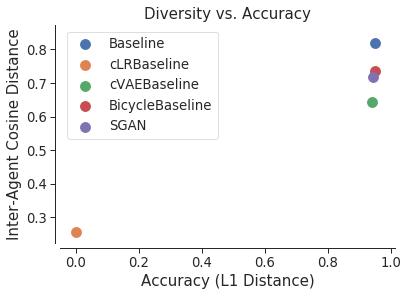

In [50]:
viz = Visualization()
ax = viz.plot.init_subplot(title='Diversity vs. Accuracy')

for model in cosine_scores:
    ax.scatter(l1_scores[model], cosine_scores[model], s=100, label=model,
               alpha=1)

ax.legend()
ax.set_ylabel('Inter-Agent Cosine Distance')
ax.set_xlabel('Accuracy (L1 Distance)')
#ax.grid(True)

plt.show()

In [75]:
order[::-1]

['SGAN', 'Baseline', 'cVAE', 'cLR', 'Bicycle']

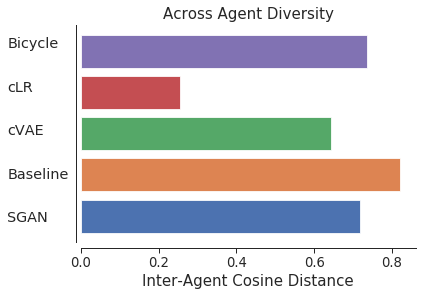

In [84]:
viz = Visualization()
ax = viz.plot.init_subplot(title='Across Agent Diversity')
order = ['Bicycle', 'cLR', 'cVAE', 'Baseline', 'SGAN'][::-1]

for i, model in enumerate(order):
    ax.barh([i], cosine_scores[model], height=0.8, alpha=1)
    ax.text(-0.22, 0.08+i*1/len(cosine_scores), model, transform=ax.transAxes,
           va='bottom', ha='left')

#ax.legend()
ax.set_xlabel('Inter-Agent Cosine Distance')
ax.set_yticks([])
#ax.set_xlabel('Accuracy (L1 Distance)')
#ax.grid(True)

plt.show()

In [ ]:
.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)[source]

### Distance matrix

In [44]:
model='BicycleBaseline'
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=True)
generator = models[model]['generator']
solver.generator = generator
ckpt = models[model]['ckpt']
solver.load_generator(model_path + ckpt)
out = solver.test(trainloader)
xy_pred = norm_scene(out['xy_pred'])
xy_out = norm_scene(out['xy_out'])

In [45]:
def dissimilarity_matrix(xy_pred, xy_out):
    max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
    # zero pad and flatten, to put into (obs, feature) matrix
    scenes = np.zeros([len(xy_out), max_size])
    for i, scene in enumerate(xy_out):
        scenes[i, :scene.size] = scene.flatten()
    scenes_pred = np.zeros([len(xy_pred), max_size])
    for i, scene in enumerate(xy_pred):
        scenes_pred[i, :scene.size] = scene.flatten()
    M = np.vstack((scenes, scenes_pred))
    dissimilarity = squareform(pdist(M, metric='cosine'))
    return dissimilarity, pdist(scenes, metric='cosine').sum(), pdist(scenes_pred, metric='cosine').sum()

In [46]:
dm = dissimilarity_matrix(xy_pred, xy_out)

In [48]:
dm[1:]

(875.4802928263807, 807.8928958832445)

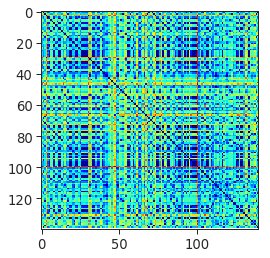

In [47]:
plt.imshow(dm[0], cmap='jet')